# Deep Learning
## Practice Projects
# P2: Multi-Label Classification

## Step 0. Style and Libraries
Let's choose a style of the Jupyter notebook and import the software libraries. The command hide_code will hide the code cells.

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                  

In [2]:
hide_code = ''
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

Using TensorFlow backend.


In [3]:
hide_code
# Plot the neural network fitting history
def history_plot(fit_history, n):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['acc'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_acc'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")    
    plt.legend()
    plt.title('Accuracy');

# Step 1. Load and Explore the Data
For this project, I have created the dataset of 5940 (180x33) color images (32x32x3) with 33 handwritten letters.
Run the following cell to download the dataset.

In [4]:
hide_code
# Function for processing an image
def image_to_tensor(img_path):
    img = keras_image.load_img("data2/" + img_path, target_size=(32, 32))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True 
# Load the data
data = pd.read_csv("data2/letters2.csv")
files = data['file'][:4320]
letters = data['letter'][:4320]
backgrounds = data['background'][:4320]
targets = data['label'][:4320].as_matrix()
tensors = data_to_tensor(files);

100%|██████████| 4320/4320 [01:35<00:00, 45.38it/s]


In [5]:
hide_code
# Print the shape 
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (4320, 32, 32, 3)
Target shape (4320,)


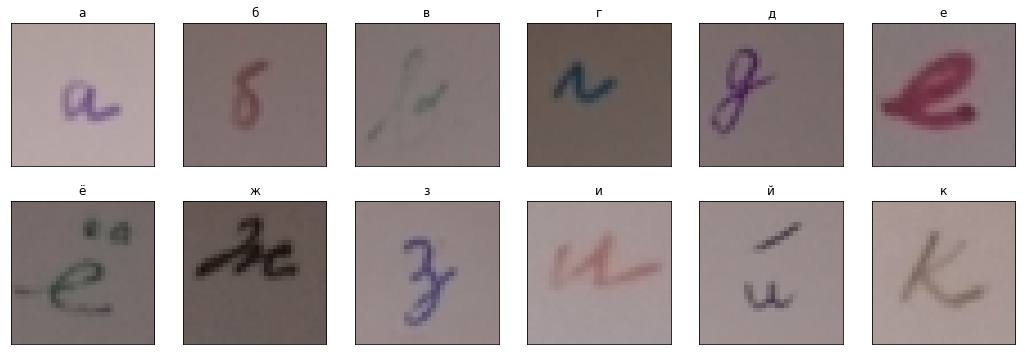

In [6]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data2/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters[i*180])
    display_images(files[i*180], ax)

## Step 2. Save and Load the Data¶
The data tensors can be saved in the appropriate format of files .h5.

In [7]:
hide_code
# Create the tensor file
with h5py.File('LetterColorImages2.h5', 'w') as f:
    f.create_dataset('images', data = tensors)
    f.create_dataset('labels', data = targets)
    f.create_dataset('backgrounds', data = backgrounds)
    f.close()

In [8]:
hide_code
# Read the h5 file
f = h5py.File('LetterColorImages2.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['backgrounds', 'images', 'labels']

In [9]:
hide_code
# Create tensors and targets
tensors = np.array(f[keys[1]])
targets = np.array(f[keys[2]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (4320, 32, 32, 3)
Target shape (4320,)


## Step 3. Implement Preprocess Functions
### Normalize and Gray Scale
In the cell below, normalize the image tensors, and return them as a normalized Numpy array.

In [10]:
hide_code
# Normalize the tensors
tensors = tensors.astype('float32')/255

Label:  е


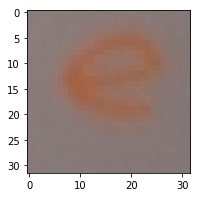

In [11]:
hide_code
# Read and display a tensor using Matplotlib
print('Label: ', letters[1000])
plt.figure(figsize=(3,3))
plt.imshow(tensors[1000]);

Create tensors of grayscaled images and display their shape.

In [12]:
hide_code
# Grayscaled tensors
gray_tensors = np.dot(tensors[...,:3], [0.299, 0.587, 0.114])
print ('Grayscaled Tensor shape:', gray_tensors.shape)

Grayscaled Tensor shape: (4320, 32, 32)


Label:  е


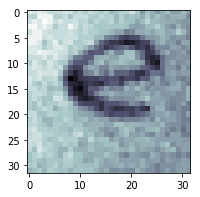

In [13]:
hide_code
# Read and display a grayscaled tensor using Matplotlib
print('Label: ', letters[1000])
plt.figure(figsize=(3,3))
plt.imshow(gray_tensors[1000], cmap=cm.bone);

### One-hot encode
Now we'll implement the one-hot encoding function to_categorical.

In [14]:
hide_code
# Print the target unique values
print(set(targets))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}


In [15]:
hide_code
# One-hot encode the targets, started from the zero label
cat_targets = to_categorical(np.array(targets-1), 24)
cat_targets.shape

(4320, 24)

In [16]:
hide_code
# One-hot encode the background targets
backgrounds = to_categorical(backgrounds)
backgrounds.shape

(4320, 3)

### Add background

In [24]:
hide_code
# Create multi-label targets
back_targets = np.concatenate((cat_targets, backgrounds), axis=1)
back_targets.shape

(4320, 27)

### Split
#### Color Images
Apply the function train_test_split and split the data into training and testing sets. Set up the size of the testing set - 20%.

In [17]:
hide_code
# Split the data
x_train, x_test, y_train, y_test = train_test_split(tensors, cat_targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

In [18]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train.shape)
print ("Training target's shape", y_train.shape)
print ("Testing tensor's shape:", x_test.shape)
print ("Testing target's shape", y_test.shape)

Training tensor's shape: (3456, 32, 32, 3)
Training target's shape (3456, 24)
Testing tensor's shape: (864, 32, 32, 3)
Testing target's shape (864, 24)


#### Grayscaled Images

In [19]:
hide_code
# Split the grayscaled data
x_train2, x_test2, y_train2, y_test2 = train_test_split(gray_tensors, cat_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)

In [20]:
hide_code
# Reshape the grayscaled data
x_train2, x_test2 = x_train2.reshape(-1, 32, 32, 1), x_test2.reshape(-1, 32, 32, 1)

In [21]:
hide_code
# Print the shape
print ("Training grayscaled tensor's shape:", x_train2.shape)
print ("Training grayscaled target's shape", y_train2.shape)
print ("Testing grayscaled tensor's shape:", x_test2.shape)
print ("Testing grayscaled target's shape", y_test2.shape)

Training grayscaled tensor's shape: (3456, 32, 32, 1)
Training grayscaled target's shape (3456, 24)
Testing grayscaled tensor's shape: (864, 32, 32, 1)
Testing grayscaled target's shape (864, 24)


In [22]:
hide_code
# Convert images from grayscaled to RGB
x_train2_tensor = tf.image.grayscale_to_rgb(x_train2, name=None)
x_test2_tensor = tf.image.grayscale_to_rgb(x_test2, name=None)
# Run tensorflow session
sess = tf.Session()
with sess.as_default():
    x_train2_color = x_train2_tensor.eval()
    x_test2_color = x_test2_tensor.eval()
# Check the shape    
x_train2_color.shape, x_test2_color.shape

((3456, 32, 32, 3), (864, 32, 32, 3))

#### Multi-label targets, color images

In [25]:
hide_code
# Split with multi-label targets
x_train3, x_test3, y_train3, y_test3 = train_test_split(tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)

In [26]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train3.shape)
print ("Training target's shape", y_train3.shape)
print ("Testing tensor's shape:", x_test3.shape)
print ("Testing target's shape", y_test3.shape)

Training tensor's shape: (3456, 32, 32, 3)
Training target's shape (3456, 27)
Testing tensor's shape: (864, 32, 32, 3)
Testing target's shape (864, 27)


In [27]:
hide_code
# Create a list of targets
y_train3_list = [y_train3[:, :24], y_train3[:, 24:]]
y_test3_list = [y_test3[:, :24], y_test3[:, 24:]]

#### Multi-label targets, grayscaled images

In [28]:
hide_code
# Split the grayscaled data
x_train4, x_test4, y_train4, y_test4 = train_test_split(gray_tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)

In [29]:
hide_code
# Reshape the grayscaled data
x_train4, x_test4 = x_train4.reshape(-1, 32, 32, 1), x_test4.reshape(-1, 32, 32, 1)

In [30]:
hide_code
# Print the shape
print ("Training grayscaled tensor's shape:", x_train4.shape)
print ("Training grayscaled target's shape", y_train4.shape)
print ("Testing grayscaled tensor's shape:", x_test4.shape)
print ("Testing grayscaled target's shape", y_test4.shape)

Training grayscaled tensor's shape: (3456, 32, 32, 1)
Training grayscaled target's shape (3456, 27)
Testing grayscaled tensor's shape: (864, 32, 32, 1)
Testing grayscaled target's shape (864, 27)


In [31]:
hide_code
# Create a list of targets
y_train4_list = [y_train4[:, :24], y_train4[:, 24:]]
y_test4_list = [y_test4[:, :24], y_test4[:, 24:]]

## Step 4. Create a One-Label Classification Model
### Color Images
Define a model architecture and compile the model for color images.

In [32]:
hide_code
def model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25)) 
    
#    model.add(Dense(128, activation='relu'))
#    model.add(Dropout(0.25))    

    model.add(Dense(24))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

model = model()

In [33]:
hide_code
# Train the model
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', 
                               verbose=2, save_best_only=True)
history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=64, verbose=2,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpointer])

Train on 3456 samples, validate on 864 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 3.16941, saving model to weights.best.model.hdf5
23s - loss: 3.1772 - acc: 0.0382 - val_loss: 3.1694 - val_acc: 0.0775
Epoch 2/10
Epoch 00001: val_loss improved from 3.16941 to 3.08660, saving model to weights.best.model.hdf5
21s - loss: 3.1495 - acc: 0.0628 - val_loss: 3.0866 - val_acc: 0.0521
Epoch 3/10
Epoch 00002: val_loss improved from 3.08660 to 3.00640, saving model to weights.best.model.hdf5
16s - loss: 3.0706 - acc: 0.0648 - val_loss: 3.0064 - val_acc: 0.0660
Epoch 4/10
Epoch 00003: val_loss did not improve
16s - loss: 3.0022 - acc: 0.0819 - val_loss: 3.1636 - val_acc: 0.0579
Epoch 5/10
Epoch 00004: val_loss improved from 3.00640 to 2.93112, saving model to weights.best.model.hdf5
17s - loss: 2.9373 - acc: 0.0883 - val_loss: 2.9311 - val_acc: 0.0694
Epoch 6/10
Epoch 00005: val_loss did not improve
16s - loss: 2.9119 - acc: 0.0964 - val_loss: 2.9599 - val_acc: 0.0926
Epoch 7/10


We should have an accuracy greater than 5%

In [34]:
hide_code
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

864/864 [==============================] - 1s     


[2.8930070753450745, 0.10069444444444445]

Apply the ImageDataGenerator() function.

In [35]:
hide_code
# Fit the model with ImageDataGenerator()
# TODO: Define parameters
steps, epochs = 1000, 10
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

generator = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),
                                steps_per_epoch = steps, epochs = epochs,
                                validation_data = (x_test, y_test), 
                                callbacks=[checkpointer], verbose=2)

Epoch 1/10
Epoch 00000: val_loss did not improve
286s - loss: 2.6712 - acc: 0.1498 - val_loss: 3.3081 - val_acc: 0.0868
Epoch 2/10
Epoch 00001: val_loss did not improve
275s - loss: 2.5302 - acc: 0.1710 - val_loss: 3.2779 - val_acc: 0.1065
Epoch 3/10
Epoch 00002: val_loss did not improve
273s - loss: 2.4534 - acc: 0.1863 - val_loss: 3.1703 - val_acc: 0.1273
Epoch 4/10
Epoch 00003: val_loss did not improve
273s - loss: 2.3997 - acc: 0.2001 - val_loss: 2.9303 - val_acc: 0.1424
Epoch 5/10
Epoch 00004: val_loss did not improve
273s - loss: 2.3614 - acc: 0.2049 - val_loss: 3.2840 - val_acc: 0.1262
Epoch 6/10
Epoch 00005: val_loss did not improve
273s - loss: 2.3206 - acc: 0.2149 - val_loss: 3.7526 - val_acc: 0.1088
Epoch 7/10
Epoch 00006: val_loss did not improve
273s - loss: 2.2913 - acc: 0.2230 - val_loss: 3.5406 - val_acc: 0.1076
Epoch 8/10
Epoch 00007: val_loss improved from 2.89301 to 2.52394, saving model to weights.best.model.hdf5
274s - loss: 2.2681 - acc: 0.2301 - val_loss: 2.5239 

In [36]:
hide_code
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

864/864 [==============================] - 1s     


[2.5239448635666459, 0.17245370370370369]

Let's compare the results with classifying algorithms.

In [37]:
hide_code
# Fit the classifier and get the accuracy score
y_train_c = np.array([np.argmax(y) for y in y_train])
y_test_c = np.array([np.argmax(y) for y in y_test])
clf = GradientBoostingClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf.score(x_test.reshape(-1, 32*32*3), y_test_c)

0.37037037037037035

In [38]:
hide_code
# Fit the classifier and get the accuracy score
clf2 = RandomForestClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf2.score(x_test.reshape(-1, 32*32*3), y_test_c)

0.28356481481481483

### Grayscaled Images

In [39]:
hide_code
def gray_model():
    model = Sequential()
    
    # TODO: Define a model architecture
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train2.shape[1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (5, 5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25)) 
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))    

    model.add(Dense(24))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

gray_model = gray_model()

In [40]:
hide_code
# Train the model
gray_checkpointer = ModelCheckpoint(filepath='weights.best.gray_model.hdf5', 
                                    verbose=2, save_best_only=True)
gray_history = gray_model.fit(x_train2, y_train2, 
                              epochs=200, batch_size=64, verbose=0,
                              validation_data=(x_test2, y_test2),
                              callbacks=[gray_checkpointer])

Epoch 00000: val_loss improved from inf to 3.17541, saving model to weights.best.gray_model.hdf5
Epoch 00001: val_loss improved from 3.17541 to 3.16743, saving model to weights.best.gray_model.hdf5
Epoch 00002: val_loss improved from 3.16743 to 3.04460, saving model to weights.best.gray_model.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss improved from 3.04460 to 3.00747, saving model to weights.best.gray_model.hdf5
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 3.00747 to 2.94362, saving model to weights.best.gray_model.hdf5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss improved from 2.94362

Epoch 00147: val_loss improved from 0.31505 to 0.28948, saving model to weights.best.gray_model.hdf5
Epoch 00148: val_loss did not improve
Epoch 00149: val_loss did not improve
Epoch 00150: val_loss did not improve
Epoch 00151: val_loss did not improve
Epoch 00152: val_loss did not improve
Epoch 00153: val_loss did not improve
Epoch 00154: val_loss did not improve
Epoch 00155: val_loss did not improve
Epoch 00156: val_loss did not improve
Epoch 00157: val_loss did not improve
Epoch 00158: val_loss did not improve
Epoch 00159: val_loss did not improve
Epoch 00160: val_loss did not improve
Epoch 00161: val_loss did not improve
Epoch 00162: val_loss did not improve
Epoch 00163: val_loss did not improve
Epoch 00164: val_loss did not improve
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did not improve
Epoch 00167: val_loss did not improve
Epoch 00168: val_loss did not improve
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss did not improve
Epoch 00171: val_loss did

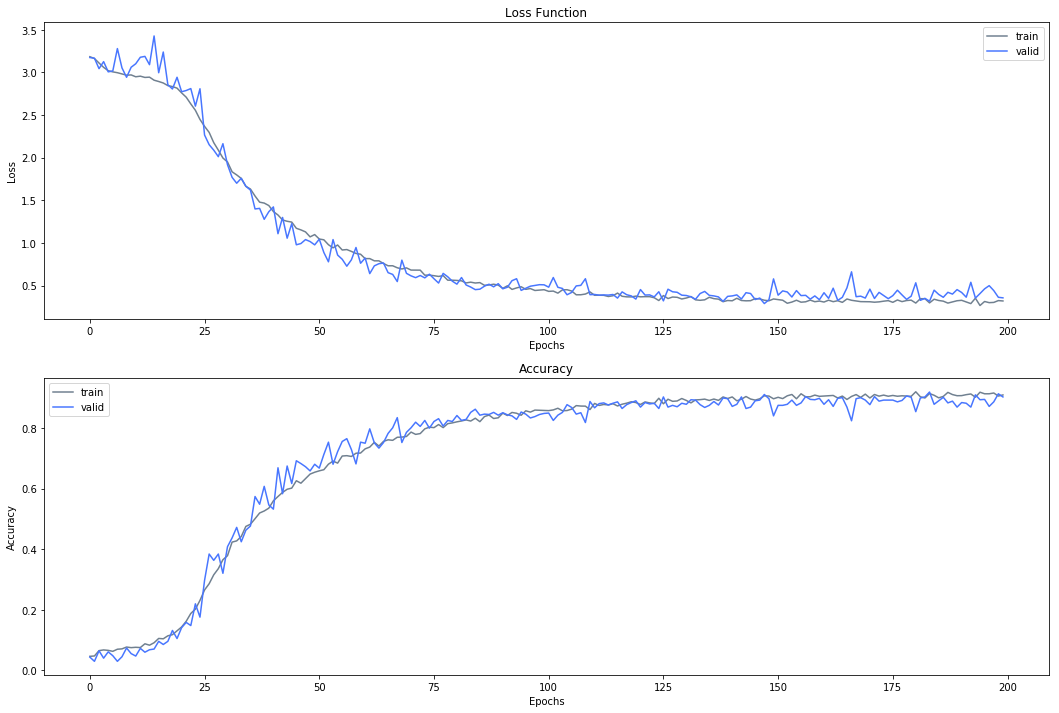

In [41]:
hide_code
# Plot the training history
history_plot(gray_history, 0)

Try to reach an accuracy greater than 80%

In [42]:
hide_code
# Load the model with the best validation accuracy
gray_model.load_weights('weights.best.gray_model.hdf5')
# Calculate classification accuracy on the testing set
gray_score = gray_model.evaluate(x_test2, y_test2)
gray_score

864/864 [==============================] - 2s     


[0.28948285982564642, 0.91087962962962965]

Apply the ImageDataGenerator() function.

In [43]:
hide_code
# Fit the model with ImageDataGenerator()
# TODO: Define parameters
steps, epochs = 1000, 10
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

gray_generator = gray_model.fit_generator(data_generator.flow(x_train2, y_train2, batch_size=64),
                                          steps_per_epoch = steps, epochs = epochs,
                                          validation_data = (x_test2, y_test2), 
                                          callbacks=[gray_checkpointer], verbose=2)

Epoch 1/10
Epoch 00000: val_loss did not improve
491s - loss: 0.8788 - acc: 0.7484 - val_loss: 0.3681 - val_acc: 0.8935
Epoch 2/10
Epoch 00001: val_loss did not improve
490s - loss: 0.8131 - acc: 0.7624 - val_loss: 0.3462 - val_acc: 0.8993
Epoch 3/10
Epoch 00002: val_loss did not improve
490s - loss: 0.7736 - acc: 0.7767 - val_loss: 0.3707 - val_acc: 0.8970
Epoch 4/10
Epoch 00003: val_loss did not improve
490s - loss: 0.7672 - acc: 0.7802 - val_loss: 0.3009 - val_acc: 0.9178
Epoch 5/10
Epoch 00004: val_loss did not improve
559s - loss: 0.7641 - acc: 0.7824 - val_loss: 0.3688 - val_acc: 0.9109
Epoch 6/10
Epoch 00005: val_loss improved from 0.28948 to 0.27393, saving model to weights.best.gray_model.hdf5
538s - loss: 0.7547 - acc: 0.7896 - val_loss: 0.2739 - val_acc: 0.9282
Epoch 7/10
Epoch 00006: val_loss did not improve
541s - loss: 0.7700 - acc: 0.7873 - val_loss: 0.4033 - val_acc: 0.8958
Epoch 8/10
Epoch 00007: val_loss did not improve
493s - loss: 0.7724 - acc: 0.7863 - val_loss: 0.

In [44]:
hide_code
# Load the model with the best validation accuracy
gray_model.load_weights('weights.best.gray_model.hdf5')
# Calculate classification accuracy on the testing set
gray_score = gray_model.evaluate(x_test2, y_test2)
gray_score

864/864 [==============================] - 1s     


[0.27392896637320518, 0.9282407407407407]

Let's compare the results with classifying algorithms.

In [45]:
hide_code
# Fit the classifier and get the accuracy score
y_train2_c = np.array([np.argmax(y) for y in y_train2])
y_test2_c = np.array([np.argmax(y) for y in y_test2])
clf = GradientBoostingClassifier().fit(x_train2.reshape(-1, 32*32), y_train2_c)
clf.score(x_test2.reshape(-1, 32*32), y_test2_c)

0.32523148148148145

In [46]:
hide_code
# Fit the classifier and get the accuracy score
clf2 = RandomForestClassifier().fit(x_train2.reshape(-1, 32*32), y_train2_c)
clf2.score(x_test2.reshape(-1, 32*32), y_test2_c)

0.22106481481481483

## Step 5. Create a Multi-Label Classification Model
### Color Images

In [47]:
hide_code
def multi_model():    
    model_input = Input(shape=(32, 32, 3))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)       
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
#    x = Dense(128, activation='relu')(x)    
#    x = Dropout(0.25)(x)    
    
    y1 = Dense(24, activation='softmax')(x)
    y2 = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=[y1, y2])
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

multi_model = multi_model()

In [48]:
hide_code
# Display the model architecture
multi_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_5 (Conv2D)                (None, 32, 32, 32)    896         input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)   (None, 16, 16, 32)    0           conv2d_5[0][0]                   
____________________________________________________________________________________________________
dropout_8 (Dropout)              (None, 16, 16, 32)    0           max_pooling2d_5[0][0]            
___________________________________________________________________________________________

In [49]:
hide_code
# Train the model
multi_checkpointer = ModelCheckpoint(filepath='weights.best.multi.hdf5', 
                                     verbose=2, save_best_only=True)
multi_history = multi_model.fit(x_train3, y_train3_list, 
                                validation_data=(x_test3, y_test3_list), 
                                epochs=100, batch_size=64, verbose=0, 
                                callbacks=[multi_checkpointer])

Epoch 00000: val_loss improved from inf to 3.24128, saving model to weights.best.multi.hdf5
Epoch 00001: val_loss improved from 3.24128 to 3.19104, saving model to weights.best.multi.hdf5
Epoch 00002: val_loss improved from 3.19104 to 3.11185, saving model to weights.best.multi.hdf5
Epoch 00003: val_loss improved from 3.11185 to 3.08090, saving model to weights.best.multi.hdf5
Epoch 00004: val_loss improved from 3.08090 to 3.01970, saving model to weights.best.multi.hdf5
Epoch 00005: val_loss improved from 3.01970 to 2.97038, saving model to weights.best.multi.hdf5
Epoch 00006: val_loss improved from 2.97038 to 2.87836, saving model to weights.best.multi.hdf5
Epoch 00007: val_loss improved from 2.87836 to 2.79424, saving model to weights.best.multi.hdf5
Epoch 00008: val_loss improved from 2.79424 to 2.78623, saving model to weights.best.multi.hdf5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 2.78623 to 2.71714, saving model to weights.best.multi.hdf5
Epoch 

We should have an accuracy greater than 5% for the first target (letter) and 100% for the second target (background).

In [50]:
hide_code
# Load the model with the best validation accuracy
multi_model.load_weights('weights.best.multi.hdf5')
# Calculate classification accuracy on the testing set
multi_scores = multi_model.evaluate(x_test3, y_test3_list, verbose=0)

print("Scores: \n" , (multi_scores))
print("First label. Accuracy: %.2f%%" % (multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (multi_scores[4]*100))

Scores: 
 [1.94997654137788, 1.9498656855689154, 0.00011085050236606212, 0.35416666666666669, 1.0]
First label. Accuracy: 35.42%
Second label. Accuracy: 100.00%


### Grayscaled Images

In [51]:
hide_code
def gray_multi_model():    
    model_input = Input(shape=(32, 32, 1))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)       
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    x = Dense(256, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    y1 = Dense(24, activation='softmax')(x)
    y2 = Dense(3, activation='softmax')(x)
       
    model = Model(inputs=model_input, outputs=[y1, y2])
    # TODO: Compile the model

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])   
    return model

gray_multi_model = gray_multi_model()

In [52]:
hide_code
# Train the model
gray_multi_checkpointer = ModelCheckpoint(filepath='weights.best.gray_multi.hdf5', 
                                          verbose=2, save_best_only=True)
gray_multi_history = gray_multi_model.fit(x_train4, y_train4_list, 
                                          validation_data=(x_test4, y_test4_list), 
                                          epochs=100, batch_size=64, verbose=0, 
                                          callbacks=[gray_multi_checkpointer])

Epoch 00000: val_loss improved from inf to 3.20109, saving model to weights.best.gray_multi.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 3.20109 to 3.17490, saving model to weights.best.gray_multi.hdf5
Epoch 00003: val_loss improved from 3.17490 to 3.17278, saving model to weights.best.gray_multi.hdf5
Epoch 00004: val_loss improved from 3.17278 to 3.05404, saving model to weights.best.gray_multi.hdf5
Epoch 00005: val_loss improved from 3.05404 to 3.00486, saving model to weights.best.gray_multi.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 3.00486 to 2.95230, saving model to weights.best.gray_multi.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 2.95230 to 2.93918, saving model to weights.best.gray_multi.hdf5
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss improved 

We should have an accuracy greater than 5% for the first target (letter) and 100% for the second target (background).

In [53]:
hide_code
# Load the model with the best validation accuracy
gray_multi_model.load_weights('weights.best.gray_multi.hdf5')
# Calculate classification accuracy on the testing set
gray_multi_scores = gray_multi_model.evaluate(x_test4, y_test4_list, verbose=0)

print("Scores: \n" , (gray_multi_scores))
print("First label. Accuracy: %.2f%%" % (gray_multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (gray_multi_scores[4]*100))

Scores: 
 [0.39172551918912818, 0.39172539997983863, 1.1920928955078125e-07, 0.8842592592592593, 1.0]
First label. Accuracy: 88.43%
Second label. Accuracy: 100.00%


## Step 6. Keras Applications
Choose one of the keras applications and try to reach an accuracy greater than 30%
### Color Images

In [ ]:
# Create bottleneck features
resize_x_train = np.array([scipy.misc.imresize(x_train[i], (139, 139, 3)) 
                           for i in range(0, len(x_train))]).astype('float32')
resize_x_test = np.array([scipy.misc.imresize(x_test[i], (139, 139, 3)) 
                          for i in range(0, len(x_test))]).astype('float32')
iv3_x_train = preprocess_input(resize_x_train)
iv3_x_test = preprocess_input(resize_x_test)
iv3_base_model = InceptionV3(weights='imagenet', include_top=False)
x_train_bn = iv3_base_model.predict(iv3_x_train)
x_test_bn = iv3_base_model.predict(iv3_x_test)

In [ ]:
# Save bottleneck features
x_train_bn = np.squeeze(x_train_bn)
x_test_bn = np.squeeze(x_test_bn)
np.save('x_train_bn.npy', x_train_bn)
np.save('x_test_bn.npy', x_test_bn)

In [ ]:
# Load bottleneck features
x_train_bn = np.load('x_train_bn.npy')
x_test_bn = np.load('x_test_bn.npy')

In [ ]:
hide_code
def iv3_model():
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(filters=32, kernel_size=2, input_shape=x_train_bn.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(16, activation='softmax'))
    # TODO: Compile the model     

    return model

iv3_model = iv3_model()

In [ ]:
hide_code
# Fit the model 
iv3_checkpointer = ModelCheckpoint(filepath='weights.best.iv3.hdf5', 
                                     verbose=2, save_best_only=True)
iv3_history = iv3_model.fit(x_train_bn, y_train, 
                            validation_data=(x_test_bn, y_test),
                            epochs=50, batch_size=64, 
                            callbacks=[iv3_checkpointer], verbose=0);

In [ ]:
hide_code
# Plot the training history
history_plot(iv3_history, 0)

In [ ]:
hide_code
# Load the model with the best validation accuracy
iv3_model.load_weights('weights.best.iv3.hdf5')
# Calculate classification accuracy on the testing set
iv3_scores = iv3_model.evaluate(x_test_bn, y_test)
print("Accuracy: %.2f%%" % (iv3_scores[1]*100))
iv3_scores

### Grayscaled Images

In [ ]:
# Create bottleneck features
resize_x_train2 = np.array([scipy.misc.imresize(x_train2_color[i], (139, 139, 3)) 
                            for i in range(0, len(x_train2_color))]).astype('float32')
resize_x_test2 = np.array([scipy.misc.imresize(x_test2_color[i], (139, 139, 3)) 
                           for i in range(0, len(x_test2_color))]).astype('float32')
iv3_x_train2 = preprocess_input(resize_x_train2)
iv3_x_test2 = preprocess_input(resize_x_test2)
iv3_base_model2 = InceptionV3(weights='imagenet', include_top=False)
x_train_bn2 = iv3_base_model2.predict(iv3_x_train2)
x_test_bn2 = iv3_base_model2.predict(iv3_x_test2)

In [ ]:
# Save bottleneck features
x_train_bn2 = np.squeeze(x_train_bn2)
x_test_bn2 = np.squeeze(x_test_bn2)
np.save('x_train_bn2.npy', x_train_bn2)
np.save('x_test_bn2.npy', x_test_bn2)

In [ ]:
# Load bottleneck features
x_train_bn2 = np.load('x_train_bn2.npy')
x_test_bn2 = np.load('x_test_bn2.npy')

In [ ]:
hide_code
def iv3_gray_model():
    model = Sequential()
    # TODO: Define a model architecture

    # TODO: Compile the model     

    return model

iv3_gray_model = iv3_gray_model()

In [ ]:
hide_code
# Fit the model 
iv3_gray_checkpointer = ModelCheckpoint(filepath='weights.best.iv3_gray.hdf5', 
                                        verbose=2, save_best_only=True)
iv3_gray_history = iv3_gray_model.fit(x_train_bn2, y_train2, 
                                      validation_data=(x_test_bn2, y_test2),
                                      epochs=50, batch_size=64, 
                                      callbacks=[iv3_gray_checkpointer], verbose=0);

In [ ]:
hide_code
# Plot the training history
history_plot(iv3_gray_history, 0)

In [ ]:
hide_code
# Load the model with the best validation accuracy
iv3_gray_model.load_weights('weights.best.iv3_gray.hdf5')
# Calculate classification accuracy on the testing set
iv3_gray_scores = iv3_gray_model.evaluate(x_test_bn2, y_test2)
print("Accuracy: %.2f%%" % (iv3_gray_scores[1]*100))
iv3_gray_scores

## Step 7. Predictions
Display predictions for the models with the best accuracy.
### Color Images

In [61]:
hide_code
# Create a list of symbols
symbols = ['а','б','в','г','д','е','ё','ж','з','и','й',
           'к','л','м','н','о','п','р','с','т','у','ф',
           'х','ц','ч','ш','щ','ъ','ы','ь','э','ю','я']

In [ ]:
hide_code
# Model predictions for the testing dataset
y_test_predict = iv3_model.predict_classes(x_test_bn)

In [ ]:
hide_code
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))

### Grayscaled Images

In [59]:
hide_code
# Model predictions for the testing dataset
y_test2_predict = gray_model.predict_classes(x_test2)

720/720 [==============================] - 4s     


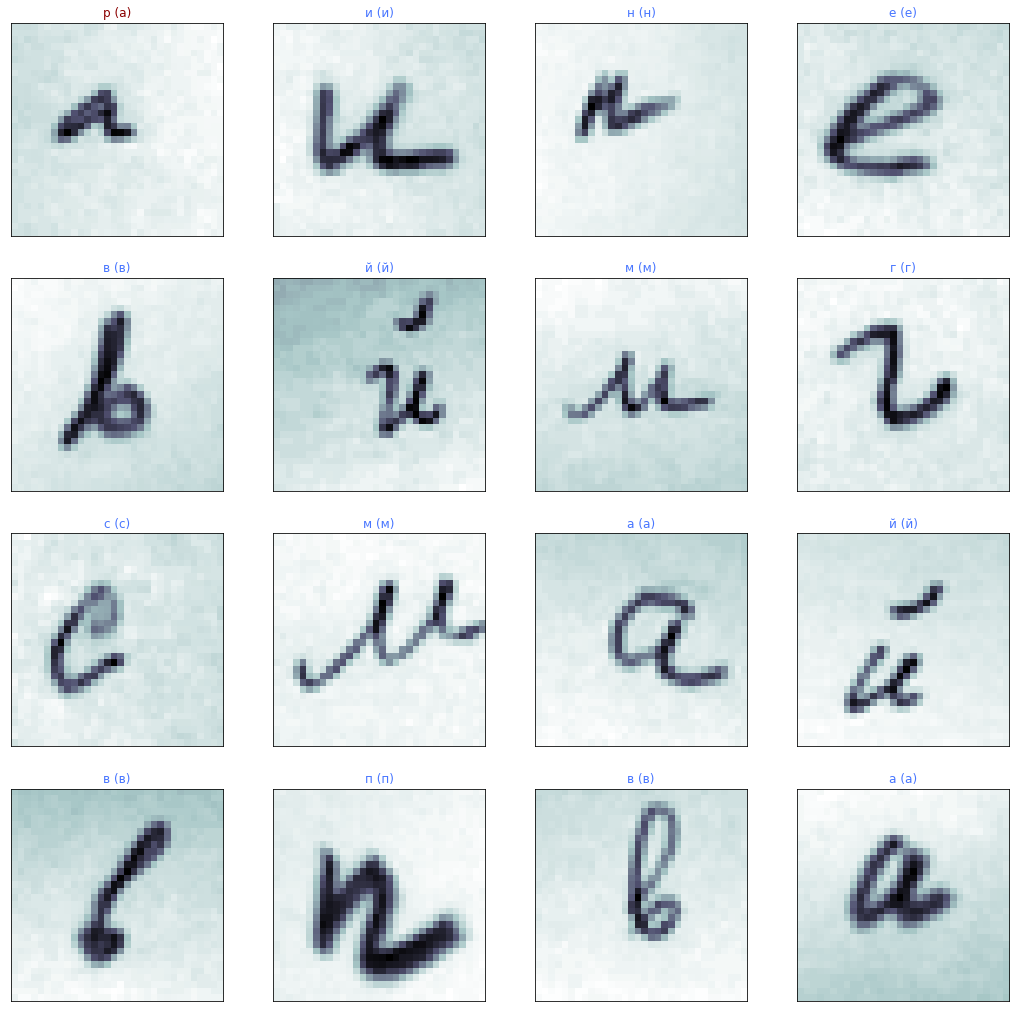

In [62]:
hide_code
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test2.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test2[idx]), cmap=cm.bone)
    pred_idx = y_test2_predict[idx]
    true_idx = np.argmax(y_test2[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))